# Función de Energía

Función de energía para resolver el problemas de optimización de encontrar el **camino más corto** entre dos nodos en un grafo. Esta función combina múltiples términos que imponen restricciones y objetivos en la solución. Aquí está la función de energía completa:

$$
F = \frac{\mu_1}{2} \sum_{i=1}^n \sum_{j=1}^n C_{ij} x_{ij} + 
    \frac{\mu_2}{2} \sum_{i=1}^n \left( \sum_{j=1}^n x_{ij} - 1 \right)^2 + 
    \frac{\mu_2}{2} \sum_{j=1}^n \left( \sum_{i=1}^n x_{ij} - 1 \right)^2 + 
    \frac{\mu_3}{2} \sum_{i=1}^n \sum_{j=1}^n x_{ij}(1 - x_{ij}) +
    \left( \sum_{j=1}^{n} x_{s,j} - 1 \right)^2 +
    \left( \sum_{i=1}^{n} x_{i,d} - 1 \right)^2
$$

## Componentes de la Función de Energía

### 1. **Coste del Camino**
$$
\frac{\mu_1}{2} \sum_{i=1}^n \sum_{j=1}^n C_{ij} x_{ij}
$$
- **Descripción**: Este término minimiza el costo total del camino.
- **Variables**:
  - $( C_{ij} $): Costo (o distancia) entre los nodos $( i $) y $( j $).
  - $(x_{ij} $): Variable binaria que indica si el camino entre $( i $) y $( j $) es parte de la solución $( x_{ij} = 1 $) o no $( x_{ij} = 0 $).
- **Propósito**: Incentivar la selección de caminos con menor costo.

---

### 2. **Restricciones de las Filas**
$
\frac{\mu_2}{2} \sum_{i=1}^n \left( \sum_{j=1}^n x_{ij} - 1 \right)^2
$
- **Descripción**: Este término asegura que cada nodo tenga exactamente **una salida**.
- **Variables**:
  - $( \sum_{j=1}^n x_{ij} $): Representa la cantidad de salidas desde el nodo $( i $).
- **Propósito**: Penalizar soluciones en las que un nodo tenga más de una salida o ninguna.

---

### 3. **Restricciones de las Columnas**
$
\frac{\mu_2}{2} \sum_{j=1}^n \left( \sum_{i=1}^n x_{ij} - 1 \right)^2
$
- **Descripción**: Este término asegura que cada nodo tenga exactamente **una entrada**.
- **Variables**:
  - $( \sum_{i=1}^n x_{ij} $): Representa la cantidad de entradas al nodo $( j $).
- **Propósito**: Penalizar soluciones en las que un nodo tenga más de una entrada o ninguna.

---

### 4. **Restricción de Binarios**
$
\frac{\mu_3}{2} \sum_{i=1}^n \sum_{j=1}^n x_{ij}(1 - x_{ij})
$
- **Descripción**: Este término obliga a que las variables $( x_{ij} $) sean binarias (0 o 1).
- **Variables**:
  - $( x_{ij} (1 - x_{ij}) $): Este producto es cero si $( x_{ij} $) es 0 o 1, pero es positivo si $( x_{ij} $) toma valores intermedios.
- **Propósito**: Penalizar valores no binarios en la solución.

---

### 5. **Restricción de Salida desde Origen**
$
\left( \sum_{j=1}^{n} x_{s,j} - 1 \right)^2
$
- **Descripción**: Este término asegura que se incluya el nodo origen en la solución.
- **Propósito**: Penaliza soluciones que no salgan desde el origen.

---

### 6. **Restricción de Llegada a Destino**
$
\left( \sum_{i=1}^{n} x_{i,d} - 1 \right)^2
$
- **Descripción**: Este término asegura que se incluya el nodo destino en la solución.
- **Propósito**: Penaliza soluciones que no lleguen a destino.


---

## Parámetros
- $( \mu_1, \mu_2, \mu_3 $): Pesos que balancean la importancia de cada término en la función.
  - $( \mu_1 $): Prioriza la minimización del costo del camino.
  - $( \mu_2 $): Enfatiza las restricciones de validez (una entrada/salida por nodo).
  - $( \mu_3 $): Controla la binariedad de las variables.

---

## RESUMEN
La función de energía combina restricciones **fuertes** (como la validez del camino) y **débiles** (como la minimización del costo y la binariedad) para:
1. **Encontrar un camino válido** entre el nodo de origen y el nodo destino.
2. **Minimizar el costo total del camino**.

Esta formulación permite resolver el problema del camino más corto mediante optimización en un modelo de red neuronal Hopfield.

---

## Modelado de los datos de la red o grafo para servir del entrada al modelo neuronal
Dada la matriz C de costes (distancias) entre nodos, consideramos que vamos a mapear el grafo a una red neuronal en la que cada neurona representa todos los posibles arcos entre nodos y en la que una neurona está encendida si el arco que representa forma parte del camino más corto.

In [2]:
# DATA PREPARATION

import pandas as pd
import numpy as np

# Load data from CSV file
try:
    df = pd.read_csv('../data/synthetic/synthetic_network.csv')
except FileNotFoundError:
    print("Error: File not found. Please check the file path.")
    exit()
except pd.errors.EmptyDataError:
    print("Error: The file is empty or invalid.")
    exit()

# Identify unique nodes and create a mapping for indices
nodos = sorted(set(df['origen']).union(set(df['destino'])))
node_to_index = {node: idx for idx, node in enumerate(nodos)}
n = len(nodos)

# Initialize the cost matrix with infinity
cost_matrix = np.full((n, n), np.inf)


# Set diagonal to 0 (self-costs)
np.fill_diagonal(cost_matrix, 0)

# Fill the cost matrix with the values from the CSV
for _, row in df.iterrows():
    try:
        origen = row['origen']
        destino = row['destino']
        costo = float(row['costo'])
        cost_matrix[node_to_index[origen], node_to_index[destino]] = costo
    except KeyError:
        print("Error: Missing columns 'origen', 'destino', or 'costo'.")
        exit()
    except ValueError:
        print(f"Error: Invalid cost value on row {_}.")
        exit()

# Display the cost matrix
print("Cost Matrix:")
print(cost_matrix)




Cost Matrix:
[[  0.  93.  inf 184.  15.  inf  86. 166.  inf  inf]
 [164.   0.  inf  inf 169.  inf  inf  inf 126. 177.]
 [151.  inf   0.  inf 163.  inf  16.  inf 114. 184.]
 [ inf  inf  inf   0.  16.  inf 103.  inf 149.  inf]
 [ inf  inf  inf  inf   0.  inf  inf  61.  62.  inf]
 [ 84.  inf  97.  inf 151.   0.  inf  inf 177.  inf]
 [ 78.  91.  inf  60.  29. 195.   0. 132.  20.  54.]
 [128.  inf  31.  inf  57.  28. 187.   0. 133.  49.]
 [ inf  inf 196. 117. 111.  22. 132.  36.   0.  inf]
 [ inf  inf  inf  inf  20.  inf  inf 145.  inf   0.]]


---

## MODELO NEURONAL

In [3]:
import tensorflow as tf
import numpy as np


C = cost_matrix

n = C.shape[0]  # Número de nodos
print("Numero de nodos")
print (n)

# Vectorizar la matriz de costes
C_flat = C.flatten()
C_flat[np.isinf(C_flat)] = 1e6  # Reemplazar infinito por un valor grande

# Función para crear el vector de entrada
def create_input_vector(C_flat, origin, destination, n):
    origin_vector = np.zeros(n)
    origin_vector[origin] = 1  # Nodo origen marcado como 1
    destination_vector = np.zeros(n)
    destination_vector[destination] = 1  # Nodo destino marcado como 1
    return np.concatenate([C_flat, origin_vector, destination_vector])

# Crear un vector de entrada con nodo origen 0 y destino 3
origin = 0
destination = 3
input_vector = create_input_vector(C_flat, origin, destination, n)

# Definir la función de pérdida con restricciones
def energy_loss_with_input_vectors(y_true, y_pred):
    # Extract the components of the input
    arc_values = y_pred[:, :n * n]  # Values for the arcs
    origin_vector = y_pred[:, n * n:n * n + n]  # Vector indicating the source node
    destination_vector = y_pred[:, n * n + n:]  # Vector indicating the destination node

    # Step 1: Cost of the path
    term1 = tf.reduce_sum(C_flat * arc_values)

    # Step 2: Constraint of one outgoing connection per node
    row_sums = tf.reduce_sum(tf.reshape(arc_values, (-1, n, n)), axis=2) - 1
    term2 = tf.reduce_sum(tf.square(row_sums))

    # Step 3: Constraint of one incoming connection per node
    col_sums = tf.reduce_sum(tf.reshape(arc_values, (-1, n, n)), axis=1) - 1
    term3 = tf.reduce_sum(tf.square(col_sums))

    # Step 4: Penalize non-binary values
    term4 = tf.reduce_sum(arc_values * (1 - arc_values))

    # Step 5: Enforce that the source node has exactly one outgoing edge
    s = tf.argmax(origin_vector, axis=1)  # Source node index
    arc_matrix = tf.reshape(arc_values, (-1, n, n))  # Reshape arcs to a matrix
    source_out = tf.gather(arc_matrix, s, batch_dims=1)  # Get the source row
    source_constraint = tf.reduce_sum(source_out, axis=1) - 1
    term5 = tf.reduce_sum(tf.square(source_constraint))

    # Step 6: Enforce that the destination node has exactly one incoming edge
    d = tf.argmax(destination_vector, axis=1)  # Destination node index
    dest_in = tf.gather(tf.transpose(arc_matrix, perm=[0, 2, 1]), d, batch_dims=1)  # Get the destination column
    dest_constraint = tf.reduce_sum(dest_in, axis=1) - 1
    term6 = tf.reduce_sum(tf.square(dest_constraint))

    # Combine all terms into the loss
    loss = term1 + 10 * term2 + 10 * term3 + 10 * term4 + 10 * term5 + 10 * term6
    return loss

# Construcción del modelo neuronal
input_dim = len(input_vector)  # Dimensión del vector de entrada
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(input_dim,)),
    tf.keras.layers.Dense(input_dim, activation='sigmoid')  # Salidas en [0, 1]
])


# Compilar el modelo
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
              loss=energy_loss_with_input_vectors)

# Entrenar el modelo (inicializar aleatoriamente las predicciones)
input_data = np.expand_dims(input_vector, axis=0)  # Añadir dimensión batch
model.fit(input_data, input_data, epochs=1000, verbose=1)

# Obtener las predicciones
predictions = model.predict(input_data)[0]

# Extraer las conexiones (arcos) del vector predicho
arc_values = predictions[:n * n]
arc_matrix = arc_values.reshape((n, n)) > 0.5  # Redondear a binario

# Mostrar el camino más corto
print("Matriz de arcos seleccionados:")
print(arc_matrix.astype(int))


2024-12-08 15:01:57.774493: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-08 15:01:57.787425: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733666517.803260  221233 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733666517.807561  221233 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-08 15:01:57.823466: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

Numero de nodos
10
Epoch 1/1000


/home/roberto/.local/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(
2024-12-08 15:02:02.398639: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 620ms/step - loss: 24006962.0000
Epoch 2/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 24006962.0000
Epoch 3/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 24006962.0000
Epoch 4/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 24006962.0000
Epoch 5/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 24006962.0000
Epoch 6/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 24006962.0000
Epoch 7/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 24006962.0000
Epoch 8/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 24006962.0000
Epoch 9/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 24006962.0000
Epoch 10/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 24006962.0000
Epoch 11/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 24006962.0000
Epoch 12/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 24006962.0000
Epoch 13/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 24006962.0000
Epoch 14/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss:

## Visualizacion del Camino más corto

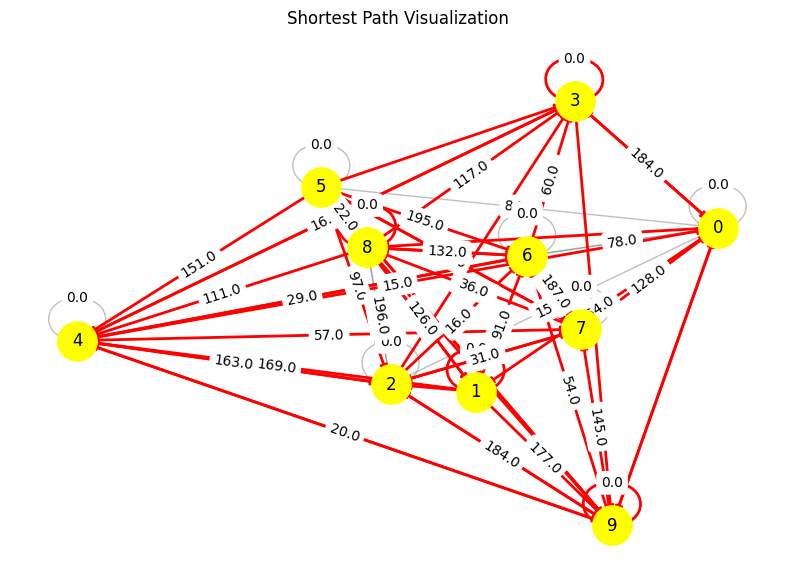

In [4]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

# Model's output
shortest_path_matrix = arc_matrix

# Example cost matrix (graph definition)
C = cost_matrix

# Replace np.inf with a large value for graph construction
C_visual = np.where(np.isinf(C), 1e6, C)

# Create a directed graph using NetworkX
G = nx.DiGraph()

# Add nodes to the graph
n = C.shape[0]
G.add_nodes_from(range(n))

# Add edges with weights
for i in range(n):
    for j in range(n):
        if C_visual[i, j] < 1e6:  # Ignore large values (infinite costs)
            G.add_edge(i, j, weight=C_visual[i, j])

# Extract the edges in the shortest path from the predictions
shortest_path_edges = [
    (i, j) for i in range(n) for j in range(n) if shortest_path_matrix[i, j] == 1
]

# Visualization
pos = nx.spring_layout(G)  # Position nodes using a spring layout
plt.figure(figsize=(10, 7))

# Draw the full graph
nx.draw_networkx_nodes(G, pos, node_color="lightblue", node_size=700, alpha=0.9)
nx.draw_networkx_edges(G, pos, edgelist=G.edges, edge_color="gray", alpha=0.5)
nx.draw_networkx_labels(G, pos, font_size=12, font_color="black")

# Highlight the shortest path
nx.draw_networkx_edges(G, pos, edgelist=shortest_path_edges, edge_color="red", width=2)
nx.draw_networkx_nodes(G, pos, nodelist=set(i for i, j in shortest_path_edges).union(j for i, j in shortest_path_edges),
                       node_color="yellow", node_size=800)

# Add edge labels with weights
edge_labels = {(i, j): f"{G.edges[i, j]['weight']}" for i, j in G.edges}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10)

# Display the plot
plt.title("Shortest Path Visualization")
plt.axis("off")
plt.show()
